In [38]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

import spacy
import en_core_web_sm
import string

from wordcloud import WordCloud

import collections
import matplotlib.cm as cm
import numpy as np
from matplotlib import rcParams

from sklearn.metrics import f1_score, classification_report, accuracy_score


from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split



In [39]:
class Task:
    def __init__(self,task):
        self.task=task
        self.nlp = en_core_web_sm.load()

    def load_dataset(self):
        if(self.task=='hate'):
            path='hate/'
            self.labels=[0,1]
            self.labels_info=["Non Hate","Hate"]
        elif(self.task=='offensive'):
            path='offensive/'
            self.labels=[0,1]
            self.labels_info=["Non Offensive","Offensive"]
        elif(self.task=='sentiment'):
            path='sentiment/'
            self.labels=[0,1,2]
            self.labels_info=["Negative","Neutral","Positive"]
        else:
            raise Exception("No such task")
        with open(path+"train_text.txt","r", encoding="utf8") as f:
            train_text=f.read()
        with open(path+"train_labels.txt","r", encoding="utf8") as f:
            train_labels=f.read()
        with open(path+"test_text.txt","r", encoding="utf8") as f:
            test_text=f.read()
        with open(path+"test_labels.txt","r", encoding="utf8") as f:
            test_labels=f.read()
        with open(path+"val_text.txt","r", encoding="utf8") as f:
            val_text=f.read()
        with open(path+"val_labels.txt","r", encoding="utf8") as f:
            val_labels=f.read() 
            
        train_text=train_text.split("\n")
        train_labels=train_labels.split("\n")

        train_text=train_text[:-1]
        train_labels=train_labels[:-1]


        data={"text":train_text,"label":train_labels}

        self.train_df=pd.DataFrame(data,columns=["text","label"])


        test_text=test_text.split("\n")
        test_labels=test_labels.split("\n")

        test_text=test_text[:-1]
        test_labels=test_labels[:-1]


        data={"text":test_text,"label":test_labels}

        self.test_df=pd.DataFrame(data,columns=["text","label"])


        val_text=val_text.split("\n")
        val_labels=val_labels.split("\n")

        val_text=val_text[:-1]
        val_labels=val_labels[:-1]


        data={"text":val_text,"label":val_labels}

        self.val_df=pd.DataFrame(data,columns=["text","label"])
        
        print("Data loaded successfully")
    def print_shape(self):
        print("Training Data Shape")
        print(self.train_df.shape)
        
        print("Validation Data Shape")
        print(self.val_df.shape)
        
        print("Testing Data Shape")
        print(self.test_df.shape)
        
    def show_train_label_dist(self):
        self.train_df['label'].value_counts().plot(kind='barh')
        
    def initial_preprocess(self,text):
        processed_text = []
        text = text.lower()
        text = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', text)
        text = re.sub(r'@[\S]+', 'USER_MENTION', text)
        text = re.sub(r'\brt\b', '', text)
        text = re.sub(r'\.{2,}', ' ', text)
        text = text.strip(' "\'')
        text = re.sub(r'\s+', ' ', text)
        words = text.split()

        for word in words:
            word = word.strip('\'"?!,.():;')
            word = re.sub(r'(.)\1+', r'\1\1', word)
            word = re.sub(r'(-|\')', '', word)
            if (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None):
                processed_text.append(word)

        return ' '.join(processed_text)
    
    
    
        
    def preprocess(self):
        
        print("Preprocessing Dataset...")
        
        self.train_df=self.train_df[self.train_df.text==self.train_df.text]
        self.val_df=self.val_df[self.val_df.text==self.val_df.text]
        self.test_df=self.test_df[self.test_df.text==self.test_df.text]
        
        self.train_df["text"]=self.train_df["text"].apply(lambda x: self.initial_preprocess(str(x)))
        self.train_df["text"]=self.train_df["text"].apply(lambda x: self.convert_emoticons(str(x)))
        self.train_df["text"]=self.train_df["text"].apply(lambda x: self.convert_emojis(str(x)))
        
        self.val_df["text"]=self.val_df["text"].apply(lambda x: self.initial_preprocess(str(x)))
        self.val_df["text"]=self.val_df["text"].apply(lambda x: self.convert_emoticons(str(x)))
        self.val_df["text"]=self.val_df["text"].apply(lambda x: self.convert_emojis(str(x)))
        
        self.test_df["text"]=self.test_df["text"].apply(lambda x: self.initial_preprocess(str(x)))
        self.test_df["text"]=self.test_df["text"].apply(lambda x: self.convert_emoticons(str(x)))
        self.test_df["text"]=self.test_df["text"].apply(lambda x: self.convert_emojis(str(x)))
        
        self.train_df["hashtags"]=self.train_df["text"].apply(lambda x: ' '.join(self.get_all_hashtags(str(x))))
        self.train_df["text"]=self.train_df["text"].apply(lambda x: self.hashtag_handling(str(x)))
        
        self.val_df["hashtags"]=self.val_df["text"].apply(lambda x: ' '.join(self.get_all_hashtags(str(x))))
        self.val_df["text"]=self.val_df["text"].apply(lambda x: self.hashtag_handling(str(x)))
        
        self.test_df["hashtags"]=self.test_df["text"].apply(lambda x: ' '.join(self.get_all_hashtags(str(x))))
        self.test_df["text"]=self.test_df["text"].apply(lambda x: self.hashtag_handling(str(x)))
        
        self.train_df["text"]=self.train_df["text"].apply(lambda x:self.expand_contractions(x))
        self.val_df["text"]=self.val_df["text"].apply(lambda x:self.expand_contractions(x))
        self.test_df["text"]=self.test_df["text"].apply(lambda x:self.expand_contractions(x))
        
        
        self.train_df["text"] =self.train_df["text"].apply(lambda x: self.remove_handles(str(x)))
        self.train_df["text"] =self.train_df["text"].apply(lambda x: re.sub('\w*\d\w*','', x))
        self.train_df["text"] =self.train_df["text"].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
        self.train_df["text"] =self.train_df["text"].str.replace("[^a-zA-Z#]", " ")
        self.train_df["text"] =self.train_df["text"].apply(lambda x: re.sub(' +',' ',x))
        self.train_df["text"] =self.train_df["text"].apply(lambda x: self.remove_short_words(str(x)))
        
        self.val_df["text"] =self.val_df["text"].apply(lambda x: self.remove_handles(str(x)))
        self.val_df["text"] =self.val_df["text"].apply(lambda x: re.sub('\w*\d\w*','', x))
        self.val_df["text"] =self.val_df["text"].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
        self.val_df["text"] =self.val_df["text"].str.replace("[^a-zA-Z#]", " ")
        self.val_df["text"] =self.val_df["text"].apply(lambda x: re.sub(' +',' ',x))
        self.val_df["text"] =self.val_df["text"].apply(lambda x: self.remove_short_words(str(x)))
        
        self.test_df["text"] =self.test_df["text"].apply(lambda x: self.remove_handles(str(x)))
        self.test_df["text"] =self.test_df["text"].apply(lambda x: re.sub('\w*\d\w*','', x))
        self.test_df["text"] =self.test_df["text"].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
        self.test_df["text"] =self.test_df["text"].str.replace("[^a-zA-Z#]", " ")
        self.test_df["text"] =self.test_df["text"].apply(lambda x: re.sub(' +',' ',x))
        self.test_df["text"] =self.test_df["text"].apply(lambda x: self.remove_short_words(str(x)))
        
        self.train_df["text"]=self.train_df["text"].apply(lambda x: self.nlp_preprocess(str(x)))
        self.val_df["text"]=self.val_df["text"].apply(lambda x: self.nlp_preprocess(str(x)))
        self.test_df["text"]=self.test_df["text"].apply(lambda x: self.nlp_preprocess(str(x)))
        
        self.train_df["label"]=pd.to_numeric(self.train_df["label"])
        self.val_df["label"]=pd.to_numeric(self.val_df["label"])
        self.test_df["label"]=pd.to_numeric(self.test_df["label"])
        
        print("Preprocessing completed successfully!")
        
        
    def train_exploratory_analysis(self):
        for label in self.labels:
            print("Analysis for "+self.labels_info[self.labels.index(label)])
            words = ' '.join([text for text in train_df['text'][self.train_df['label'] == label]])
            wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)
        
        

            plt.figure(figsize=(10, 7))
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis('off')
            plt.show()


            counted_words = collections.Counter(words.split(" "))

            words = []
            counts = []
            for letter, count in counted_words.most_common(20):
                words.append(letter)
                counts.append(count)

            colors = cm.rainbow(np.linspace(0, 1, 20))
            rcParams['figure.figsize'] = 20, 10

            plt.title('Top words in the '+self.labels_info[self.labels.index(label)]+' tweets vs their count')
            plt.xlabel('Count')
            plt.ylabel('Words')
            plt.barh(words, counts, color=colors)
            plt.show()
            
            print()
        
        
        
        
    def convert_emojis(self,text):
        for emot in UNICODE_EMO:
            text = text.replace(emot, " ".join(UNICODE_EMO[emot].replace(",","").replace(":","").replace("_"," ").split()))
        return text
    def convert_emoticons(self,text):
        for emot in EMOTICONS:
            text = re.sub(u'('+emot+')', " ".join(EMOTICONS[emot].replace(",","").replace("_"," ").split()), text)
        return text
    def get_all_hashtags(self,input_txt):
        input_txt=input_txt.replace("#"," #")
        hashtags = [tag.strip("#") for tag in input_txt.split() if tag.startswith("#")]

        return hashtags


    def hashtag_handling(self,input_txt):
        hashtags=get_all_hashtags(input_txt)
        for tag in hashtags:
            input_txt=input_txt.replace("#"+tag,tag)
        return input_txt
    
    def expand_contractions(self,text):
        contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

        # Regular expression for finding contractions
        contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
        def replace(match):
            return contractions_dict[match.group(0)]
        return contractions_re.sub(replace, text)
    def remove_handles(self,input_txt):
        r = re.findall("@[\w]*", input_txt)
        for i in r:
            input_txt = re.sub(i, '', input_txt)

        return input_txt 

    def remove_short_words(self,input_txt):
        return ' '.join([w for w in input_txt.split() if len(w)>3])
    
    def nlp_preprocess(self,input_txt):
        if(input_txt==input_txt): 
            doc = self.nlp(input_txt)

            spacy_words = [t.lemma_ for t in doc if ((not t.is_stop) and (t.pos_ != 'PUNCT'))]
            sentence=" ".join(spacy_words)
            return sentence
        
    def nb(self):
        X = self.train_df.text.values
        y = self.train_df.label.values

        X_train, X_val, y_train, y_val =\
            train_test_split(X, y, test_size=0.1, random_state=1986)
        
        tf_idf = TfidfVectorizer(smooth_idf=False)
        X_train_tfidf = tf_idf.fit_transform(X_train)
        X_val_tfidf = tf_idf.transform(X_val)
        
        
        
        
        model = MultinomialNB(alpha=1.8)
        
        kf = StratifiedKFold(5, shuffle=True, random_state=1)

        auc = cross_val_score(
            model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)
        auc=auc.mean()
        
        
        model.fit(X_train_tfidf,y_train)
        predictions = model.predict(X_val_tfidf)
        print("Naive Bayes - Training")
        print()
        
        print("acc:",accuracy_score(predictions, y_val)*100)
        print("roc_auc:",auc)
        print('f1-macro:',f1_score(y_val, predictions, average='macro'))
        print('f1-weighted:',f1_score(y_val, predictions, average='weighted'))
        print('f1-micro:',f1_score(y_val, predictions, average='micro'))
        print()
        
        ###############################################################
        X_val = self.val_df.text.values
        y_val = self.val_df.label.values
        
        X_val_tfidf = tf_idf.transform(X_val)
        
        predictions = model.predict(X_val_tfidf)
        print("Naive Bayes - Validation")
        print()
        
        print("acc:",accuracy_score(predictions, y_val)*100)
        print("roc_auc:",auc)
        print('f1-macro:',f1_score(y_val, predictions, average='macro'))
        print('f1-weighted:',f1_score(y_val, predictions, average='weighted'))
        print('f1-micro:',f1_score(y_val, predictions, average='micro'))
        print()
        
        ################################################################
        X_val = self.test_df.text.values
        y_val = self.test_df.label.values
        
        X_val_tfidf = tf_idf.transform(X_val)
        
        predictions = model.predict(X_val_tfidf)
        print("Naive Bayes - Testing")
        print()
        
        print("acc:",accuracy_score(predictions, y_val)*100)
        print("roc_auc:",auc)
        print('f1-macro:',f1_score(y_val, predictions, average='macro'))
        print('f1-weighted:',f1_score(y_val, predictions, average='weighted'))
        print('f1-micro:',f1_score(y_val, predictions, average='micro'))
        print()
        
    def svm(self):
        X = self.train_df.text.values
        y = self.train_df.label.values

        X_train, X_val, y_train, y_val =\
            train_test_split(X, y, test_size=0.1, random_state=1986)
        
        tf_idf = TfidfVectorizer(smooth_idf=False)
        X_train_tfidf = tf_idf.fit_transform(X_train)
        X_val_tfidf = tf_idf.transform(X_val)
        
        
        model = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
        
         kf = StratifiedKFold(5, shuffle=True, random_state=1)

        auc = cross_val_score(
            model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)
        auc=auc.mean()
        
        
        model.fit(X_train_tfidf,y_train)
        predictions = model.predict(X_val_tfidf)
        print("SVM - Training")
        print()
        
        print("acc:",accuracy_score(predictions, y_val)*100)
        print("roc_auc:",auc)
        print('f1-macro:',f1_score(y_val, predictions, average='macro'))
        print('f1-weighted:',f1_score(y_val, predictions, average='weighted'))
        print('f1-micro:',f1_score(y_val, predictions, average='micro'))
        print()
        
        ###############################################################
        X_val = self.val_df.text.values
        y_val = self.val_df.label.values
        
        X_val_tfidf = tf_idf.transform(X_val)
        
        predictions = model.predict(X_val_tfidf)
        print("SVM - Validation")
        print()
        
        print("acc:",accuracy_score(predictions, y_val)*100)
        print("roc_auc:",auc)
        print('f1-macro:',f1_score(y_val, predictions, average='macro'))
        print('f1-weighted:',f1_score(y_val, predictions, average='weighted'))
        print('f1-micro:',f1_score(y_val, predictions, average='micro'))
        print()
        
        ################################################################
        X_val = self.test_df.text.values
        y_val = self.test_df.label.values
        
        X_val_tfidf = tf_idf.transform(X_val)
        
        predictions = model.predict(X_val_tfidf)
        print("SVM - Testing")
        print()
        
        print("acc:",accuracy_score(predictions, y_val)*100)
        print("roc_auc:",auc)
        print('f1-macro:',f1_score(y_val, predictions, average='macro'))
        print('f1-weighted:',f1_score(y_val, predictions, average='weighted'))
        print('f1-micro:',f1_score(y_val, predictions, average='micro'))
        print()
        

Data loaded successfully
Training Data Shape
(9000, 2)
Validation Data Shape
(1000, 2)
Testing Data Shape
(2970, 2)
Preprocessing Dataset...
Preprocessing completed successfully!
Training Data Shape
(9000, 3)
Validation Data Shape
(1000, 3)
Testing Data Shape
(2970, 3)
Analysis for Non Hate


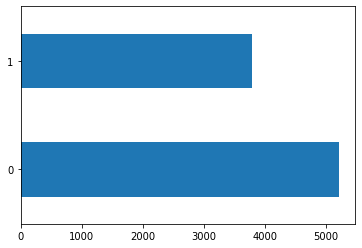

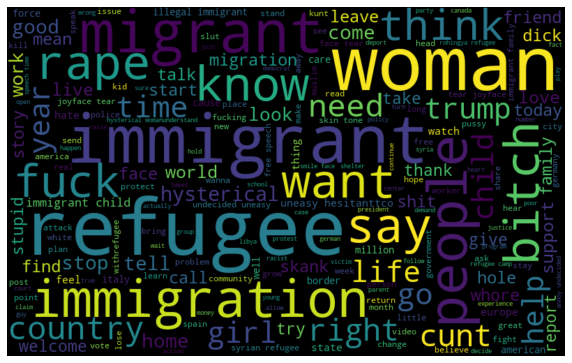

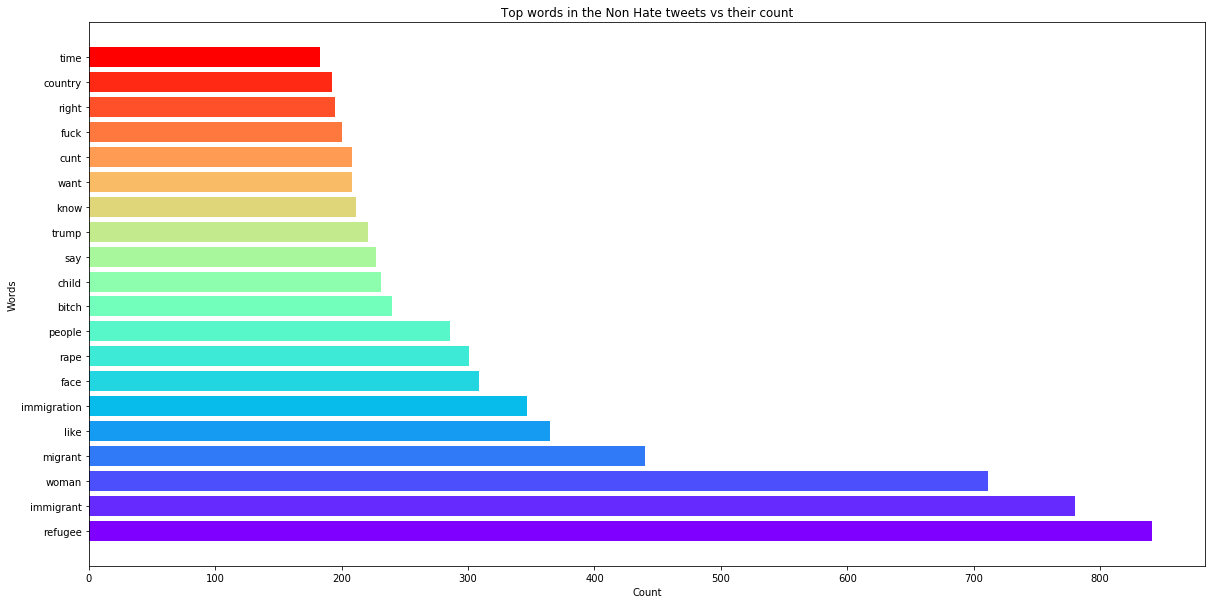


Analysis for Hate


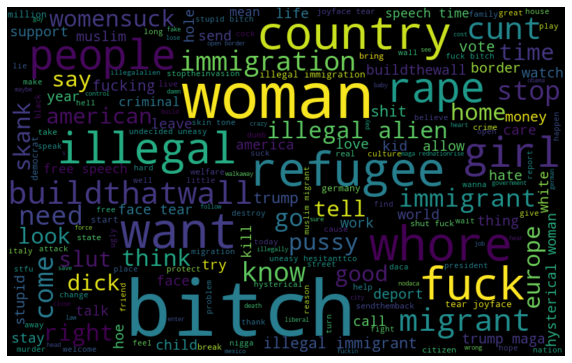

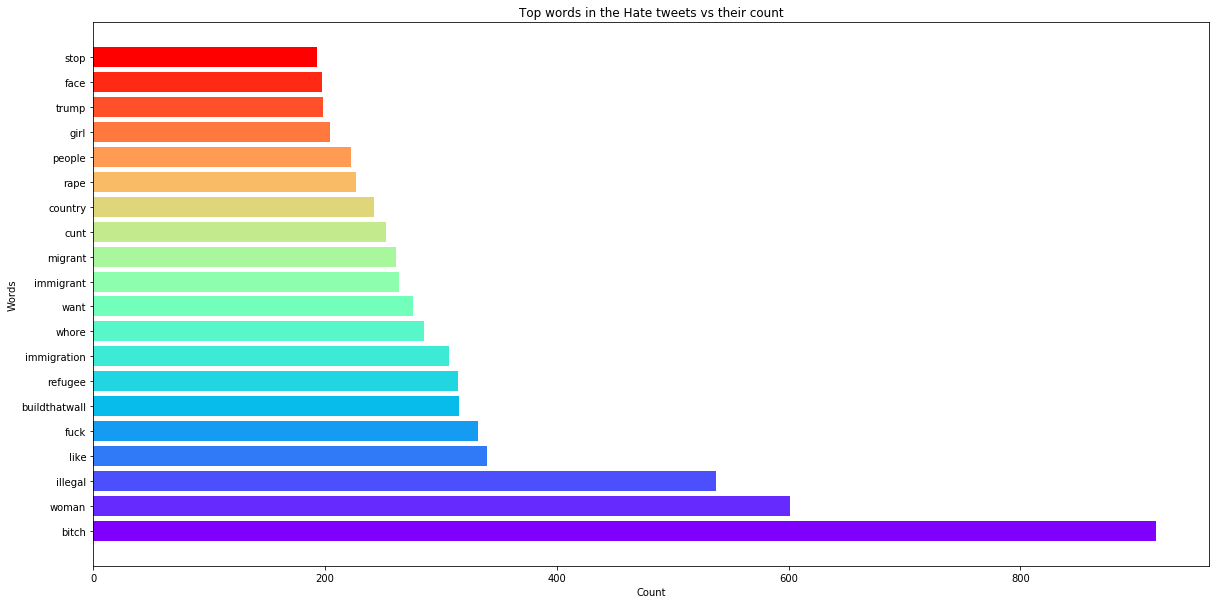


Naive Bayes
Training Dataset:

acc: 68.66666666666667
roc_auc: [0.76046916 0.76288566 0.75761106 0.75138929 0.74957819]
f1-macro: 0.6639496639496639
f1-weighted: 0.674628596850819
f1-micro: 0.6866666666666666



In [40]:
task=Task("hate")
task.load_dataset()
task.print_shape()
task.preprocess()
task.print_shape()
task.show_train_label_dist()
task.train_exploratory_analysis()
task.nb()
task.svm()

In [4]:
with open("hate/train_text.txt","r", encoding="utf8") as f:
    train_text=f.read()
with open("hate/train_labels.txt","r", encoding="utf8") as f:
    train_labels=f.read()
with open("hate/test_text.txt","r", encoding="utf8") as f:
    test_text=f.read()
with open("hate/test_labels.txt","r", encoding="utf8") as f:
    test_labels=f.read()
with open("hate/val_text.txt","r", encoding="utf8") as f:
    val_text=f.read()
with open("hate/val_labels.txt","r", encoding="utf8") as f:
    val_labels=f.read()    
    
train_text=train_text.split("\n")
train_labels=train_labels.split("\n")

train_text=train_text[:-1]
train_labels=train_labels[:-1]


data={"text":train_text,"label":train_labels}

train_df=pd.DataFrame(data,columns=["text","label"])


test_text=test_text.split("\n")
test_labels=test_labels.split("\n")

test_text=test_text[:-1]
test_labels=test_labels[:-1]


data={"text":test_text,"label":test_labels}

test_df=pd.DataFrame(data,columns=["text","label"])


val_text=val_text.split("\n")
val_labels=val_labels.split("\n")

val_text=val_text[:-1]
val_labels=val_labels[:-1]


data={"text":val_text,"label":val_labels}

val_df=pd.DataFrame(data,columns=["text","label"])

In [5]:
train_df.shape

(9000, 2)

In [6]:
test_df.shape

(2970, 2)

In [7]:
val_df.shape

(1000, 2)

In [8]:
train_df

,text,label
0,@user nice new signage. Are you not concerned ...,0
1,A woman who you fucked multiple times saying y...,1
2,@user @user real talk do you have eyes or were...,1
3,your girlfriend lookin at me like a groupie in...,1
4,Hysterical woman like @user,0
...,...,...
8995,Oooohhhh bitch didn't even listen to the dead ...,0
8996,@user Good Luck @user More Americans #WalkAway...,0
8997,Bitch you can't keep up so stop trying,1
8998,@user @user @user @user @user @user Japan is a...,0


In [9]:
#### https://pub.towardsai.net/emoticon-and-emoji-in-text-mining-7392c49f596a


def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, " ".join(UNICODE_EMO[emot].replace(",","").replace(":","").replace("_"," ").split()))
    return text
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', " ".join(EMOTICONS[emot].replace(",","").replace("_"," ").split()), text)
    return text

train_df["text"]=train_df["text"].apply(lambda x: str(x).lower())
train_df["text"]=train_df["text"].apply(lambda x: convert_emoticons(str(x)))
train_df["text"]=train_df["text"].apply(lambda x: convert_emojis(str(x)))

In [10]:
def get_all_hashtags(input_txt):
    input_txt=input_txt.replace("#"," #")
    hashtags = [tag.strip("#") for tag in input_txt.split() if tag.startswith("#")]

    return hashtags

    
def hashtag_handling(input_txt):
    hashtags=get_all_hashtags(input_txt)
    for tag in hashtags:
        input_txt=input_txt.replace("#"+tag,tag)
    return input_txt

train_df["hashtags"]=train_df["text"].apply(lambda x: ' '.join(get_all_hashtags(str(x))))
train_df["text"]=train_df["text"].apply(lambda x: hashtag_handling(str(x)))

In [11]:
train_df.loc[503,"hashtags"]

'stop_islamization stopinvasion  complicedisalvini refugeesnotwelcome'

In [12]:
train_df.loc[503,"text"]

'@user @user @user stop the invasion of 3rd world immigrants. support europeans to have more children. preserve our culture and history. stop islam! stop_islamization stopinvasion complicedisalvini refugeesnotwelcome '

In [13]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
train_df["text"]=train_df["text"].apply(lambda x:expand_contractions(x))

In [14]:
#### https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/

nlp = en_core_web_sm.load()



def remove_handles(input_txt):
    r = re.findall("@[\w]*", input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

def remove_short_words(input_txt):
    return ' '.join([w for w in input_txt.split() if len(w)>3])

train_df["text"] =train_df["text"].apply(lambda x: remove_handles(str(x)))
train_df["text"] =train_df["text"].apply(lambda x: re.sub('\w*\d\w*','', x))
train_df["text"] =train_df["text"].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
train_df["text"] = train_df["text"].str.replace("[^a-zA-Z#]", " ")
train_df["text"] =train_df["text"].apply(lambda x: re.sub(' +',' ',x))
train_df["text"] =train_df["text"].apply(lambda x: remove_short_words(str(x)))

In [15]:
def nlp_preprocess(input_txt):
    if(input_txt==input_txt): 
        doc = nlp(input_txt)

        spacy_words = [t.lemma_ for t in doc if ((not t.is_stop) and (t.pos_ != 'PUNCT'))]
        sentence=" ".join(spacy_words)
        return sentence
    
train_df["text"]=train_df["text"].apply(lambda x: nlp_preprocess(str(x)))

In [16]:
train_df["label"]=pd.to_numeric(train_df["label"])

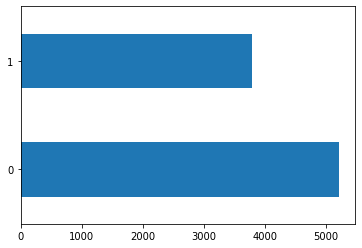

In [17]:
train_df['label'].value_counts().plot(kind='barh')
train_df['label'].value_counts().plot(kind='barh')

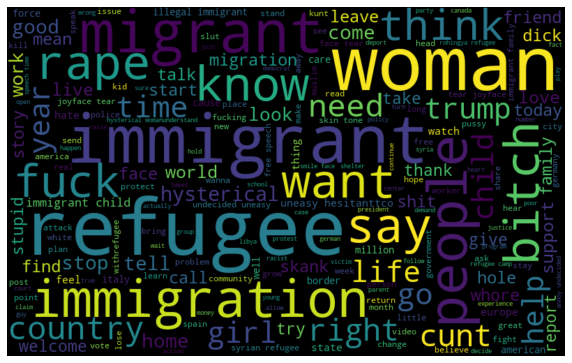

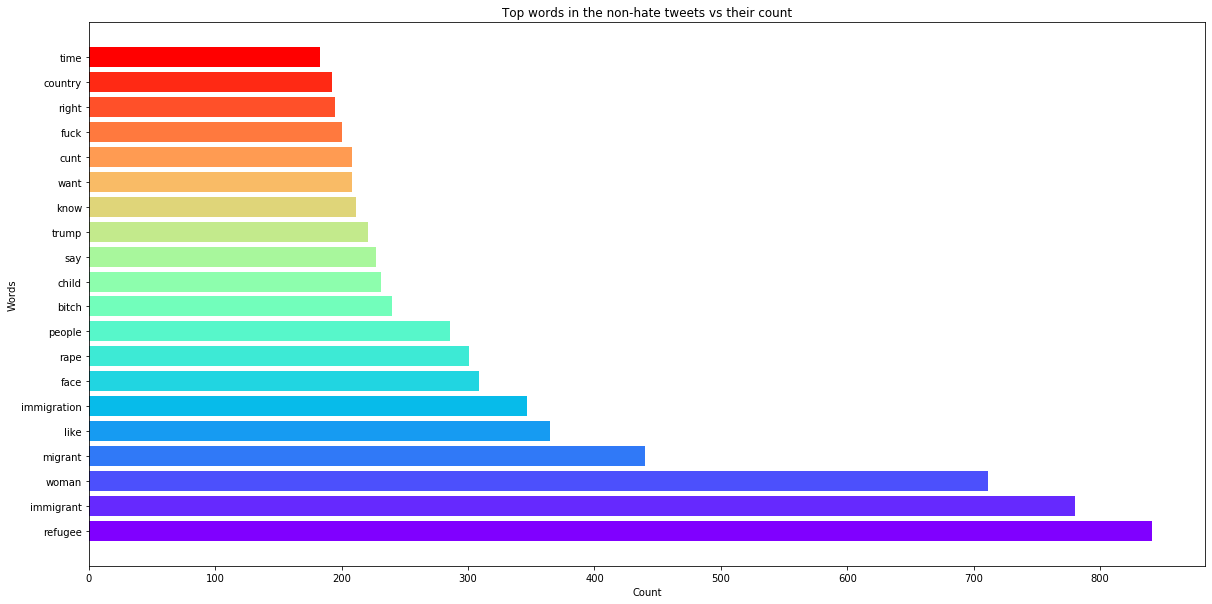

In [16]:

nonhate_words = ' '.join([text for text in train_df['text'][train_df['label'] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(nonhate_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


#### https://towardsdatascience.com/identify-top-topics-using-word-cloud-9c54bc84d911



counted_words = collections.Counter(nonhate_words.split(" "))

words = []
counts = []
for letter, count in counted_words.most_common(20):
    words.append(letter)
    counts.append(count)
    
colors = cm.rainbow(np.linspace(0, 1, 20))
rcParams['figure.figsize'] = 20, 10

plt.title('Top words in the non-hate tweets vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)
plt.show()

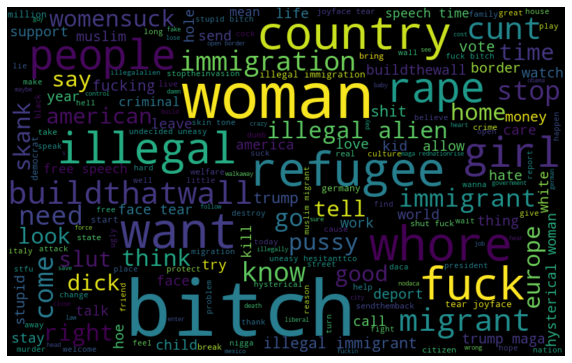

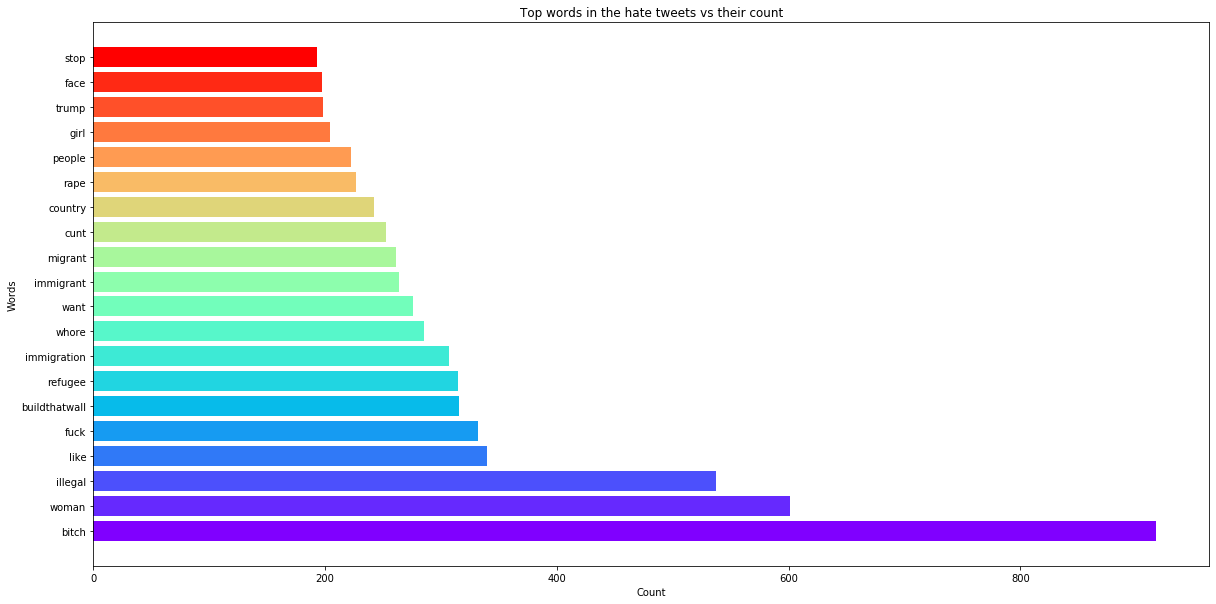

In [17]:
hate_words = ' '.join([text for text in train_df['text'][train_df['label'] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(hate_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

counted_words = collections.Counter(hate_words.split(" "))

words = []
counts = []
for letter, count in counted_words.most_common(20):
    words.append(letter)
    counts.append(count)
    
colors = cm.rainbow(np.linspace(0, 1, 20))
rcParams['figure.figsize'] = 20, 10

plt.title('Top words in the hate tweets vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)
plt.show()

In [18]:

X = train_df.text.values
y = train_df.label.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=2020)



# Calculate TF-IDF
tf_idf = TfidfVectorizer(smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train)
X_val_tfidf = tf_idf.transform(X_val)

In [19]:
X_train_tfidf.shape

(8100, 13417)

In [20]:
X_val_tfidf.shape

(900, 13417)

In [21]:

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

Best alpha:  2.0


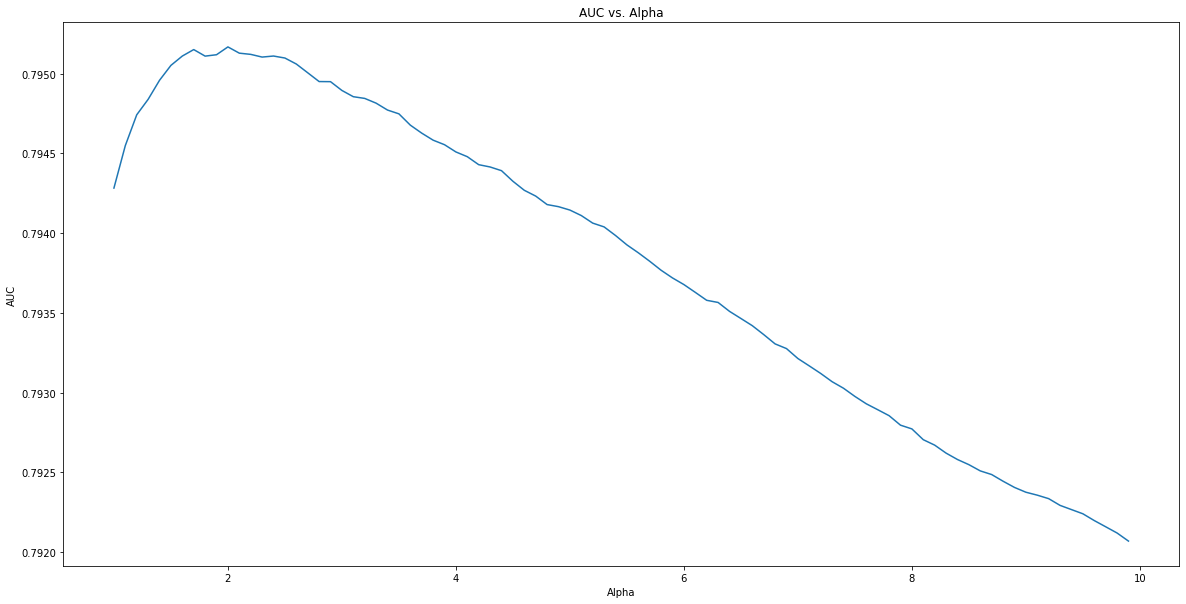

In [270]:


res = pd.Series([get_auc_CV(MultinomialNB(i))
                 for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

In [271]:


def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.8068
Accuracy: 73.11%


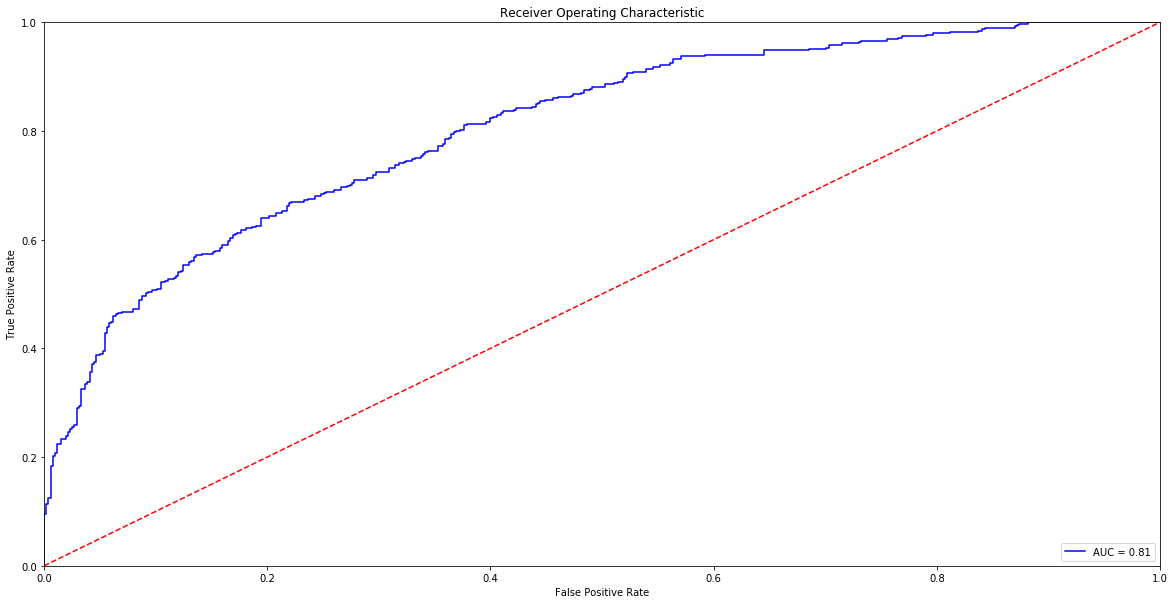

In [272]:
nb_model = MultinomialNB(alpha=1.8)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_val)

In [1]:
import time
count = 0
start = time.time()
for i in range (1000000000):
    count = count+1
end = time.time()

print (end - start)

76.62743210792542
